### Organized 3D Point Clouds

We demonstrate Polylidar3D being applied to an organized point cloud. Depth images from an Intel RealSense D435i will be processed. This example is taken from the much more thorough script titled `realsense_mesh.py`. Refer to that script for more details.

In [ ]:
import time
import logging
import sys
import os
from IPython.display import Image
SRC_DOCS = os.path.realpath(os.path.join(os.getcwd(), '..', '..', '..', 'src_docs', '_static' ))
sys.path.insert(0, '../../../')

In [11]:
import numpy as np
import open3d as o3d
from open3d import JVisualizer
import matplotlib.pyplot as plt

from examples.python.util.realsense_util import (get_realsense_data, get_frame_data, R_Standard_d400, prep_mesh,
                                                 create_open3d_pc, extract_mesh_planes, COLOR_PALETTE)

from polylidar import (Polylidar3D, MatrixDouble, MatrixFloat, extract_tri_mesh_from_float_depth,
                       extract_point_cloud_from_float_depth)

from polylidar.polylidarutil.open3d_util import construct_grid, create_lines, flatten, create_open_3d_mesh_from_tri_mesh
from polylidar.polylidarutil.plane_filtering import filter_planes_and_holes

from examples.python.realsense_mesh import filter_and_create_open3d_polygons, run_test, callback


First we gather the data and visualize. The point cloud is colored by z-height,the blue points represent the floor of my basement.

In [3]:
color_files, depth_files, traj, intrinsics = get_realsense_data()
pcd, rgbd, extrinsics = get_frame_data(4, color_files, depth_files, traj, intrinsics, stride=2)
pcd = pcd.rotate(R_Standard_d400[:3, :3], center=False)
logging.info("File %r - Point Cloud; Size: %r", 4, np.asarray(pcd.points).shape[0])
o3d.visualization.draw_geometries([pcd])

INFO:root:File 4 - Point Cloud; Size: 24817


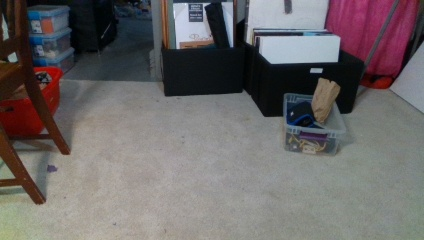

In [15]:
Image(f"{color_files[4]}")

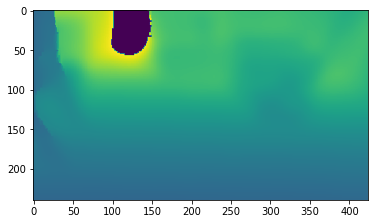

In [16]:
plt.imshow(np.asarray(rgbd.depth))

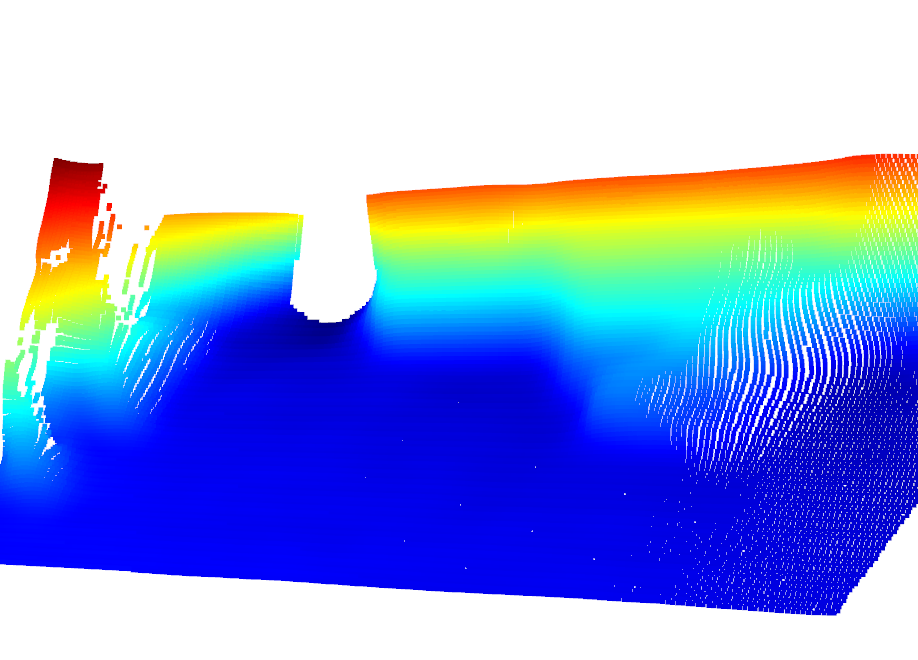

In [4]:
Image(f"{SRC_DOCS}/organized/organized_pc_raw.png")

In [5]:
run_test(pcd, rgbd, intrinsics, extrinsics, callback=callback, stride=2)

INFO:root:Treated as **Unorganized** Point Cloud - 2.5D Delaunay Triangulation with Polygon Extraction took 14.71 milliseconds
INFO:root:Treated as **Organized** Point Cloud - Right-Cut Triangulation/Uniform Mesh (Mesh only) took 1.33 milliseconds
INFO:root:Polygon Extraction on Uniform Mesh (only one dominant plane normal) took 2.62 milliseconds


This is the result of generating a Right-Cut Triangulaton/Uniform Mesh from the organized point cloud. It only took around a millisecond.

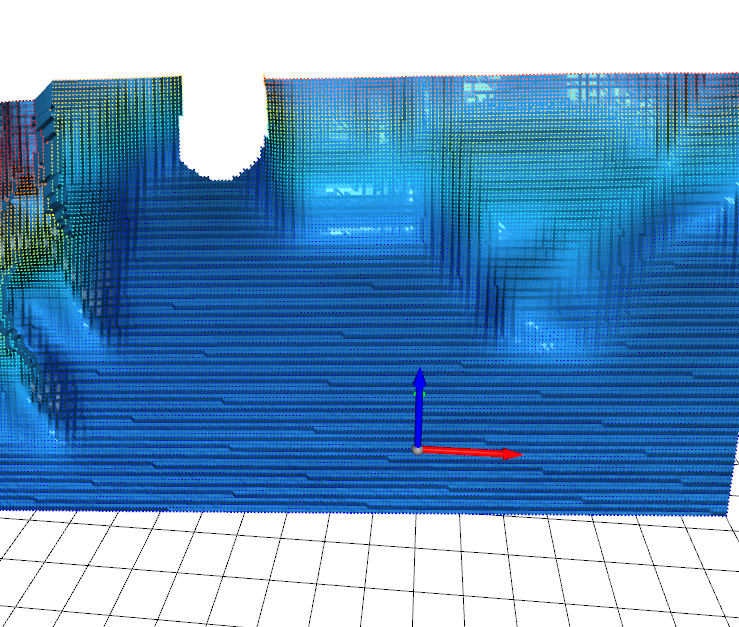

In [7]:
Image(f"{SRC_DOCS}/organized/organized_mesh.png")

Here is the result of using Polylidar3D to extract planar triangular segments and their polygonal representations which have similar orienation to the floor normal.
The basement floor is extracted as a polygon (green line). Notice that there were small holes in the mesh; these were filtered out with the parameter `min_hole_vertices`. Notice other planar segments were extracted (purple, red, orange, etc.). These can/were filtered out by either `min_triangles` or polygon post-processing with minimum area requirements.

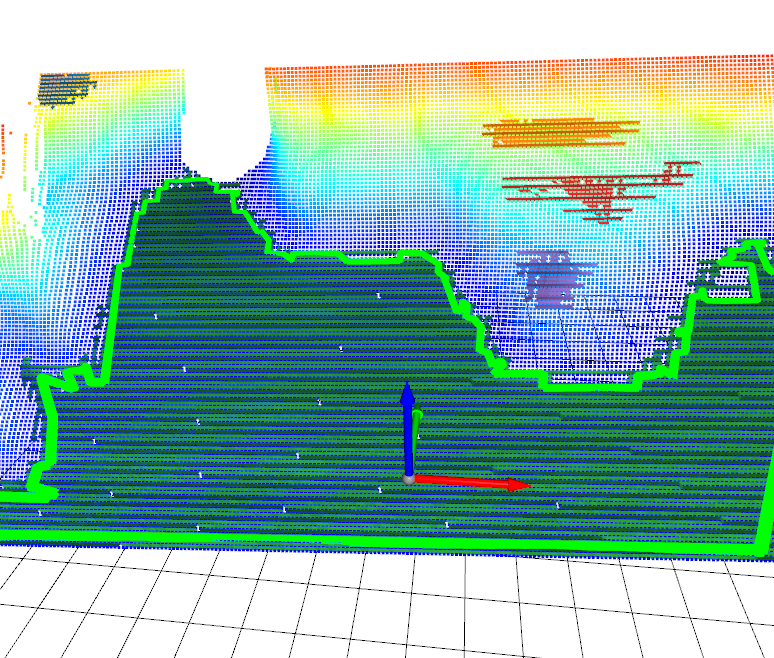

In [9]:
Image(f"{SRC_DOCS}/organized/organized_polygons.png")

See `realsense_mesh.py` to see how these images are exactly created. However the basics work like this

1. First create a half-edge triangular mesh of the depth image. Triangles are removed from invalid depth measurements (i.e.., 0).
2. Call Polylidar3D to extract Planes and Polygons from the mesh.
3. Filter polygons with polygon post-processing

Note that Polylidar3D can just take an organized point cloud *directly* if you have it: [extract_tri_mesh_from_organized_point_cloud](../../python_api/polylidar.extract_tri_mesh_from_organized_point_cloud.rst)

In [28]:
tri_mesh = extract_tri_mesh_from_float_depth(MatrixFloat(
    np.asarray(rgbd.depth)), MatrixDouble(np.ascontiguousarray(intrinsics.intrinsic_matrix)), MatrixDouble(extrinsics), stride=2)
num_triangles = np.asarray(tri_mesh.triangles).shape[0]

print(f"Number of triangles: {num_triangles}")

# Create Polylylidar3D object for extraction (you can keep using on more frames later if you desire)
polylidar_kwargs = dict(alpha=0.0, lmax=0.10, min_triangles=100,
                        z_thresh=0.04, norm_thresh=0.90, norm_thresh_min=0.90, min_hole_vertices=6)
pl = Polylidar3D(**polylidar_kwargs)

planes, polygons = pl.extract_planes_and_polygons(tri_mesh)
num_planes = len(planes)
print(f"Number of planar segments: {len(planes)}")
print(f"Number of polygons : {len(polygons)}")

points = np.asarray(tri_mesh.vertices)
config_pp = dict(filter=dict(hole_area=dict(min=0.025, max=100.0), hole_vertices=dict(min=6), plane_area=dict(min=0.5)),
                 positive_buffer=0.00, negative_buffer=0.02, simplify=0.01)

polygon_shells, polygons_holes = filter_planes_and_holes(polygons, points, config_pp)

print(f"Number of polygons after filtering: {len(polygon_shells)}")

Number of triangles: 48914
Number of planar segments: 5
Number of polygons : 5
Number of polygons after filtering: 1
